In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style()
from tqdm.notebook import tqdm

Сначала загрузим себе датасет с философскими и религиозными текстами с Kaggle:

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('tentotheminus9/religious-and-philosophical-texts', path='data/religious', unzip=True)

Возьмём в качестве нашего текста проповеди Будды. Немного предобработки, чтобы обрезать заголовок и индекс с лицензием, не помешает:

In [3]:
text_lines = open('data/religious/35895-0.txt', 'r').readlines()[526:9639]

text_lines[:10]

['I.\n',
 '\n',
 'REJOICE!\n',
 '\n',
 '\n',
 'Rejoice at the glad tidings! The Buddha, our Lord, has found the\n',
 'root of all evil; he has shown us the way of salvation.              1\n',
 '\n',
 'The Buddha dispels the illusions of our mind and redeems us from\n',
 'the terror of death.                                                 2\n']

Так как эта книга в довольно интересном формате, то строчки получаются очень грязными. Почистим их чуть позже (будем использовать разные способы для этого).

In [4]:
from typing import List
from collections import Counter
from itertools import chain

def build_vocab(texts: List[str]) -> Counter:
    words = list(chain.from_iterable([text.split() for text in texts]))
    vocab = Counter(words)
    return vocab

vocab = build_vocab(text_lines)

len(vocab), list(vocab.items())[:10]

(10670,
 [('I.', 2),
  ('REJOICE!', 1),
  ('Rejoice', 2),
  ('at', 162),
  ('the', 5420),
  ('glad', 8),
  ('tidings!', 3),
  ('The', 361),
  ('Buddha,', 92),
  ('our', 110)])

Определённо это не то как мы хотим видеть наши слова. [Украдём](https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text) с kaggle классный препроцессор:

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing import Iterable

class TextPreprocessor:
    def __init__(self):
        nltk.download('stopwords')
        nltk.download('wordnet')
        self.lemmatizer_ = WordNetLemmatizer()
        self.stopwords_ = stopwords.words('english')

    def remove_litter(self, text: str) -> str:
        is_allowed_char = lambda c: c.isalpha() or c == ' '
        text = ''.join(list(filter(is_allowed_char, text)))
        return text
        
    def remove_stopwords(self, tokens: Iterable[str]) -> Iterable[str]:
        return filter(lambda token : token not in self.stopwords_, tokens)
    
    def lemmatize(self, tokens: Iterable[str]) -> Iterable[str]:
        return map(self.lemmatizer_.lemmatize, tokens)
    
    def preprocess(self, text: str, lemmatize=True) -> str:
        result = self.remove_litter(text.lower())
        result = self.remove_stopwords(result.split())
        if lemmatize:
            result = self.lemmatize(result)
        return ' '.join(result)
    
    def preprocess_all(self, texts: Iterable[str], lemmatize=True) -> List[str]:
        processed = map(lambda text : self.preprocess(text, lemmatize=lemmatize), texts)
        filtered = filter(lambda text : len(text) > 0, processed)
        
        return list(filtered)

In [6]:
tp = TextPreprocessor()
    
processed_text_lines = tp.preprocess_all(tqdm(text_lines))
processed_vocab = build_vocab(processed_text_lines)

len(processed_vocab), processed_vocab.most_common(15)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/covariance/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/covariance/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/9113 [00:00<?, ?it/s]

(5386,
 [('one', 758),
  ('blessed', 526),
  ('said', 367),
  ('truth', 362),
  ('thou', 304),
  ('buddha', 289),
  ('life', 212),
  ('man', 195),
  ('thy', 182),
  ('world', 165),
  ('king', 164),
  ('mind', 162),
  ('good', 149),
  ('self', 148),
  ('lord', 146)])

## Модельки

Объявим несколько хелперов:

In [7]:
def visualize_vec(vec, name):
    _, ax = plt.subplots(figsize=(10, .5))
    ax.tick_params(left=False, bottom=False)
    ax.set_title(name)
    sns.heatmap([vec], cmap=sns.color_palette('mako'), yticklabels=False, xticklabels=False, cbar=False)
    plt.show()

### gensim

In [8]:
from gensim.models import Word2Vec

model_gensim = Word2Vec(
    sentences=[line.split() for line in processed_text_lines],
    sg=False,  # cbow model
    window=5,
    seed=42, 
    min_count=1
)

def get_gensim_vec(name):
    return model_gensim.wv[name]

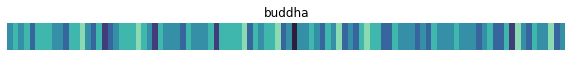

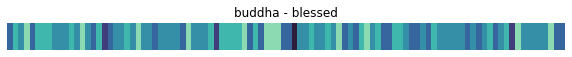

In [9]:
visualize_vec(get_gensim_vec('buddha'), 'buddha')
visualize_vec(get_gensim_vec('buddha') - get_gensim_vec('blessed'), 'buddha - blessed')

In [10]:
model_gensim.wv.most_similar('buddha')

[('like', 0.996953010559082),
 ('world', 0.996798038482666),
 ('mind', 0.9964592456817627),
 ('one', 0.9963293075561523),
 ('truth', 0.9962827563285828),
 ('great', 0.9960709810256958),
 ('let', 0.9960565567016602),
 ('thou', 0.9960248470306396),
 ('man', 0.9958925247192383),
 ('heart', 0.9958759546279907)]

### BERT

In [11]:
import torch
from transformers import BertTokenizer, BertModel

model_bert = BertModel.from_pretrained(
    'bert-base-uncased',
    output_hidden_states = True,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_vocab = build_vocab(tp.preprocess_all(text_lines, lemmatize=False))

def make_word_embedding(text: str) -> torch.Tensor:
    # Получим индексы токенов
    tokenized_query = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_query)
    segments_ids = [1] * len(indexed_tokens)
    
    # to tensor 
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    # calc embeddings
    outputs = model_bert(tokens_tensor, segments_tensors)
    last_layer_embs = outputs[2][-1]
    sentense_embedding = last_layer_embs.squeeze(0).sum(dim=0)
    
    return sentense_embedding

def get_bert_vec(name: str):
    return make_word_embedding(name).cpu().detach().numpy()

def get_bert_most_similar(name: str):
    vec = get_bert_vec(name)
    return get_bert_most_similar_vec(vec)

def get_bert_most_similar_vec(vec):
    ans = ''
    words = list(zip(*bert_vocab.items()))[0]
    nearest_words = []
    for word in tqdm(words):
        word_vec = get_bert_vec(word)
        result = np.dot(vec, word_vec) / (np.linalg.norm(vec) * np.linalg.norm(word_vec))  
        nearest_words.append((result, word))
    nearest_words.sort(key=lambda tup: tup[0])
    return nearest_words

def get_bert_most_similar(word: str):
    vec = get_bert_vec(word)
    return list(zip(*(get_bert_most_similar_vec(vec)[::-1])))[1]

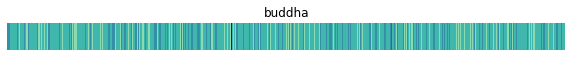

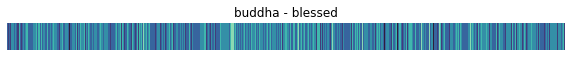

In [13]:
visualize_vec(get_bert_vec('buddha'), 'buddha')
visualize_vec(get_bert_vec('buddha') - get_bert_vec('blessed'), 'buddha - blessed')

## Описание

<== Testing bert model ==>


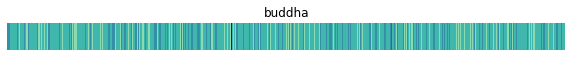

  0%|          | 0/5964 [00:00<?, ?it/s]

Closest to buddha: buddha buddhas buddhaelect buddhahood sake yoketh yoked manasākata sun yoke
<== Testing gensim model ==>


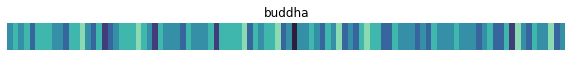

Closest to buddha: like world mind one truth great let thou man heart


In [14]:
getters = {
    'bert' : get_bert_vec,
    'gensim' : get_gensim_vec
}

close_finders = {
    'bert' : get_bert_most_similar,
    'gensim' : lambda word : list(zip(*(model_gensim.wv.most_similar(word))))[0]
}

def test_models(word):
    for model in ('bert', 'gensim'):
        print('<== Testing %s model ==>' % model)
        getter = getters[model]
        close_finder = close_finders[model]
        
        visualize_vec(getter(word), word)
        
        closest = close_finder(word)
        closest_str = ' '.join(closest[:10])
        print('Closest to %s: %s' % (word, closest_str))
        
test_models('buddha')

In [18]:
text_embeds = [
    make_word_embedding(word).detach().numpy()
        for word in tqdm(list(zip(*bert_vocab.items()))[0])
]

  0%|          | 0/5964 [00:00<?, ?it/s]

In [20]:
from torch.utils.tensorboard import SummaryWriter

# Hackity hack
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

with SummaryWriter() as writer:
    writer.add_embedding(np.array(text_embeds), metadata=list(zip(*bert_vocab.items()))[0])

In [21]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 79666), started 0:06:24 ago. (Use '!kill 79666' to kill it.)